In [2]:
# Get Winsorizer
!pip install feature_engine --user

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.1/364.1 kB 2.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 65.5 MB/s eta 0:00:00:00:01:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.22.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.10.0, but you have google-cloud-bigquery 2.34.4 which is incompatible.
bigframes 0.22.0 requires google-cloud-storage>=2.0.0, but you have google-cloud-storage 1.44.0 which is incompatible.
bigframes 0.22.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.2.2 which is incompatible.
dataproc-jupyter-plugin 0.1.79 requires pydantic~=1.10.0, but you have pydantic 2.8.2 which is incompatible.
spaghetti 1.7.6 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
spopt 0.6.1 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompa

In [3]:
# Data wrangling
import numpy as np
import pandas as pd
import os
from feature_engine.outliers import Winsorizer # Outlier handling


# Data visualization tools
import matplotlib.pyplot as plt
import seaborn as sns

# Utils
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2, RFE, SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import pickle
import time

# ML Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

# Sampling
from imblearn.over_sampling import SMOTE


# Evaluation Metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings("ignore")

In [4]:
# Import our dataset
df = pd.read_csv("/kaggle/input/us-drought-meteorological-data/train_timeseries/train_timeseries.csv")
df.head()

,fips,date,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,...,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score
0,1001,2000-01-01,0.22,100.51,9.65,14.74,13.51,13.51,20.96,11.46,...,14.65,2.20,2.94,1.49,1.46,4.85,6.04,3.23,2.81,NaN
1,1001,2000-01-02,0.20,100.55,10.42,16.69,14.71,14.71,22.80,12.61,...,16.60,2.52,3.43,1.83,1.60,5.33,6.13,3.72,2.41,NaN
2,1001,2000-01-03,3.65,100.15,11.76,18.49,16.52,16.52,22.73,15.32,...,18.41,4.03,5.33,2.66,2.67,7.53,9.52,5.87,3.66,NaN
3,1001,2000-01-04,15.95,100.29,6.42,11.40,6.09,6.10,18.09,2.16,...,11.31,3.84,5.67,2.08,3.59,6.73,9.31,3.74,5.58,1.0
4,1001,2000-01-05,0.00,101.15,2.95,3.86,-3.29,-3.20,10.82,-2.66,...,2.65,1.60,2.50,0.52,1.98,2.94,4.85,0.65,4.19,NaN


# The Problem:

We are trying to predict the degree of Drought in different seasons and throughout the years.

This is a multiclass classification problem with five different classes.

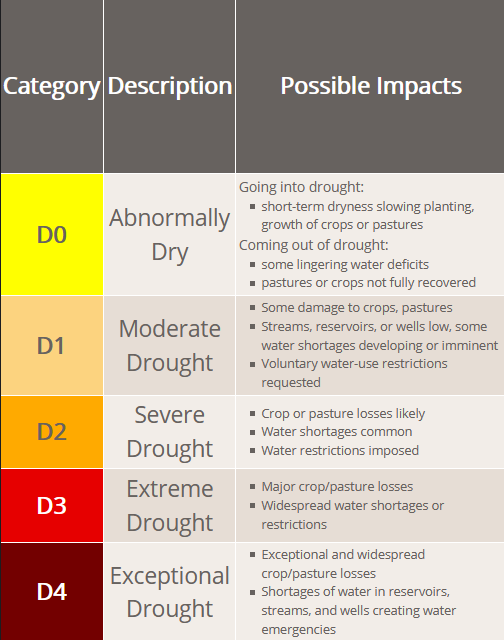

### Value counts

Our target count is not equally distributed and the numbers are not rounded.

We will handle these issues later on.

In [5]:
df["score"].value_counts()

score
0.0000    1480827
1.0000     219135
2.0000     123789
3.0000      82801
4.0000      45841
           ...   
0.1734          1
0.4052          1
1.5706          1
1.5485          1
3.0717          1
Name: count, Length: 55395, dtype: int64

In [6]:
# Analyze our dataframe: dtypes, columns, memory usage, total data count
display(df.info())
display(df.size)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19300680 entries, 0 to 19300679
Data columns (total 21 columns):
 #   Column       Dtype  
---  ------       -----  
 0   fips         int64  
 1   date         object 
 2   PRECTOT      float64
 3   PS           float64
 4   QV2M         float64
 5   T2M          float64
 6   T2MDEW       float64
 7   T2MWET       float64
 8   T2M_MAX      float64
 9   T2M_MIN      float64
 10  T2M_RANGE    float64
 11  TS           float64
 12  WS10M        float64
 13  WS10M_MAX    float64
 14  WS10M_MIN    float64
 15  WS10M_RANGE  float64
 16  WS50M        float64
 17  WS50M_MAX    float64
 18  WS50M_MIN    float64
 19  WS50M_RANGE  float64
 20  score        float64
dtypes: float64(19), int64(1), object(1)
memory usage: 3.0+ GB


None

405314280

In [7]:
# Removing the null values in the target variable as the drought score is only available for once in 7 days.

df.isnull().sum()

fips                  0
date                  0
PRECTOT               0
PS                    0
QV2M                  0
T2M                   0
T2MDEW                0
T2MWET                0
T2M_MAX               0
T2M_MIN               0
T2M_RANGE             0
TS                    0
WS10M                 0
WS10M_MAX             0
WS10M_MIN             0
WS10M_RANGE           0
WS50M                 0
WS50M_MAX             0
WS50M_MIN             0
WS50M_RANGE           0
score          16543884
dtype: int64

# Drop NA

We don't synthesize more target count (score) because of the fact we have plenty of data already.

In [8]:
# Drop null values
df.dropna(inplace=True)

We transform our dates(year, month, day) into appropriate time windows using time library

Our score variable is a float, we round it to the appropriate dtype = INT

In [9]:
df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month
df['day'] = pd.DatetimeIndex(df['date']).day
df['score'] = df['score'].round().astype(int)
df.dtypes

fips             int64
date            object
PRECTOT        float64
PS             float64
QV2M           float64
T2M            float64
T2MDEW         float64
T2MWET         float64
T2M_MAX        float64
T2M_MIN        float64
T2M_RANGE      float64
TS             float64
WS10M          float64
WS10M_MAX      float64
WS10M_MIN      float64
WS10M_RANGE    float64
WS50M          float64
WS50M_MAX      float64
WS50M_MIN      float64
WS50M_RANGE    float64
score            int64
year             int32
month            int32
day              int32
dtype: object

### Missing value check

In [10]:
print("df has missing values:", df.isnull().any().any())

df has missing values: False


## Target Value Counts

In [11]:
# We can re-run the value counts to see the rounded scores' counts
df["score"].value_counts()

score
0    1652230
1     466944
2     295331
3     196802
4     106265
5      39224
Name: count, dtype: int64

Our data is not evenly distributed, we will address this when Sampling

In [12]:
# Check for duplicates
duplicates = df.duplicated().any()
print(f"Does the DataFrame have duplicated rows? {duplicates}")

Does the DataFrame have duplicated rows? False


# EDA

In [13]:
# For numeric columns
display(df.describe().T)

# For Categorical columns
display(df.describe(include=['object']))

,count,mean,std,min,25%,50%,75%,max
fips,2756796.0,30670.376770,14979.110105,1001.00,19044.50,29212.00,46007.50,56043.00
PRECTOT,2756796.0,2.714566,6.247590,0.00,0.00,0.19,2.26,168.69
PS,2756796.0,96.647365,5.444698,66.49,95.83,98.28,99.94,103.76
QV2M,2756796.0,7.875770,4.721459,0.14,3.81,6.94,11.45,22.12
T2M,2756796.0,12.899230,10.970402,-35.44,4.58,14.21,22.00,39.33
T2MDEW,2756796.0,7.049350,10.197650,-35.44,-0.88,7.81,15.67,26.87
T2MWET,2756796.0,7.084938,10.143641,-35.46,-0.84,7.81,15.67,26.87
T2M_MAX,2756796.0,18.767110,11.602952,-30.03,10.36,20.62,27.97,47.75
T2M_MIN,2756796.0,7.519916,10.618183,-40.85,-0.57,8.26,16.28,32.28
T2M_RANGE,2756796.0,11.247201,4.038022,0.16,8.37,11.20,14.08,30.17


,date
count,2756796
unique,887
top,2016-12-27
freq,3108


In [14]:
cols = list(df.columns)
cols

['fips',
 'date',
 'PRECTOT',
 'PS',
 'QV2M',
 'T2M',
 'T2MDEW',
 'T2MWET',
 'T2M_MAX',
 'T2M_MIN',
 'T2M_RANGE',
 'TS',
 'WS10M',
 'WS10M_MAX',
 'WS10M_MIN',
 'WS10M_RANGE',
 'WS50M',
 'WS50M_MAX',
 'WS50M_MIN',
 'WS50M_RANGE',
 'score',
 'year',
 'month',
 'day']

## Visualize the distribution of each numeric measurement column

In [15]:
#Get numeric features out into a list and remove unnecessary features
measures_list = [x for x in df.select_dtypes(include=["int64", "float64", "int32"])]
remove_list = ["fips", "score", "year", "month", "day"]

# List comprehension for applying remove_list to our measures_list
measures_list = [i for i in measures_list if i not in remove_list]
# Create measures_df out of df with only the numeric features we want to visualize
measures_df = df[measures_list]

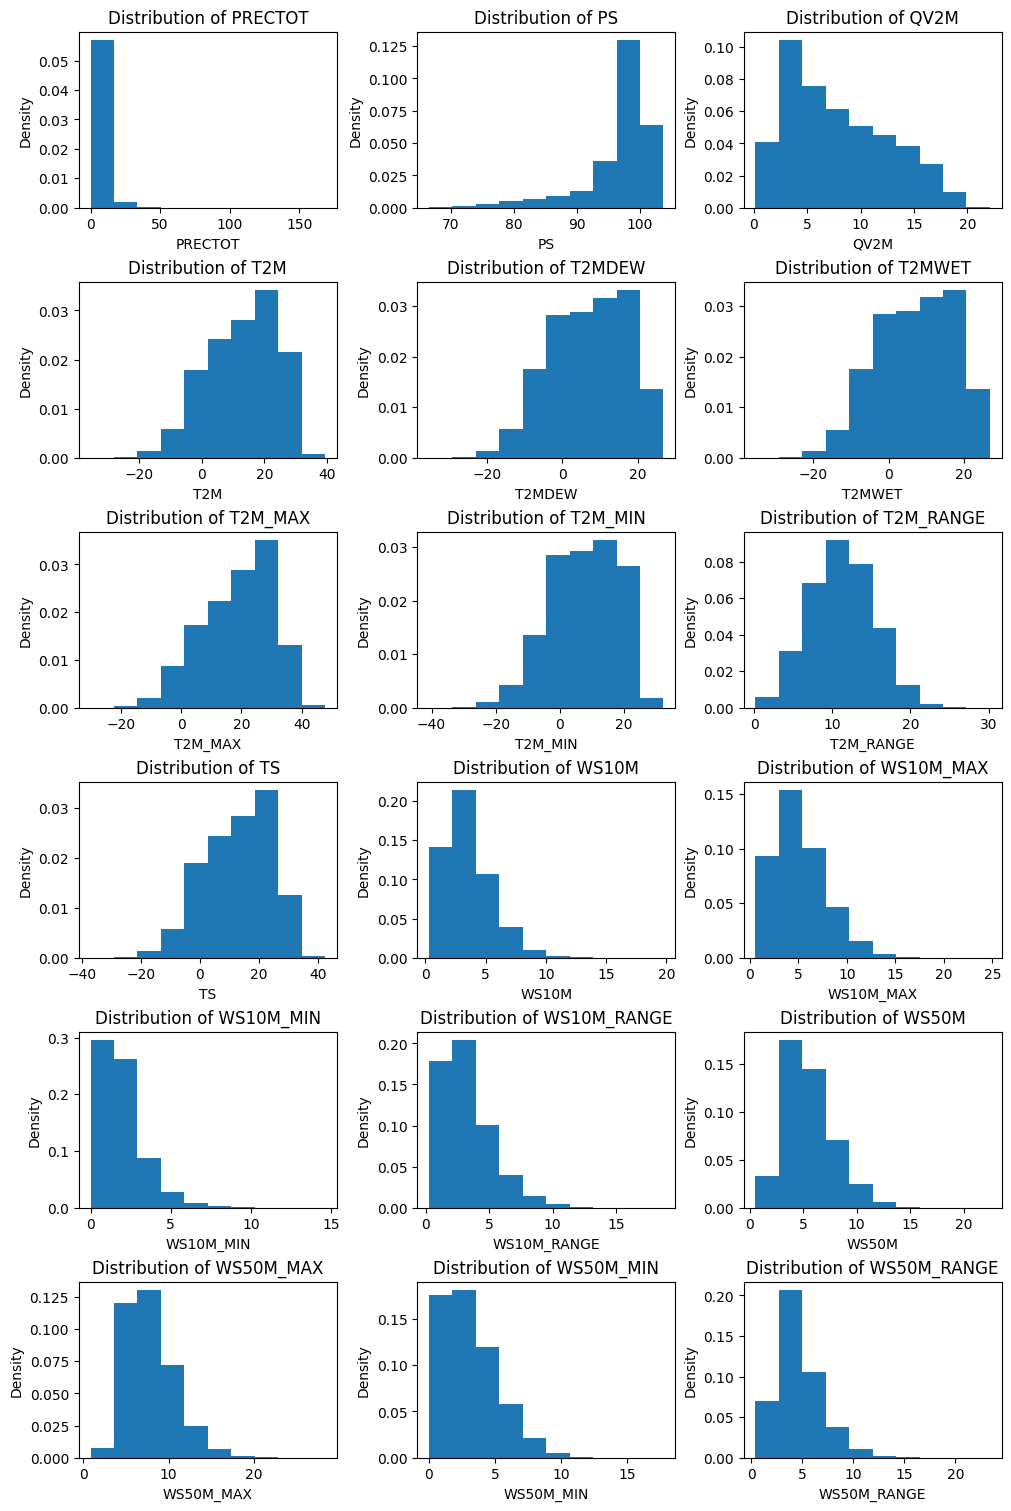

In [16]:
num_cols = 3  # Number of histograms per figure
num_rows = (len(measures_list) + num_cols - 1) // num_cols  # Calculate number of rows needed

# Create a figure with subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 15), constrained_layout=True)

# Flatten the axes array for easier iteration
axes = axes.flatten()

for i, col_name in enumerate(measures_list):
    ax = axes[i]
    ax.hist(measures_df[col_name], density=True)
    ax.set_xlabel(col_name)
    ax.set_ylabel('Density')
    ax.set_title(f'Distribution of {col_name}')

# Turn off axes for any unused subplots
for j in range(len(measures_list), len(axes)):
    axes[j].axis('off')

plt.show()

Conclusion: We can conclude that the majority of our numeric measurement are normally distributed with a few right or left skewed distributions to which we can observe above

# Outlier Visualization

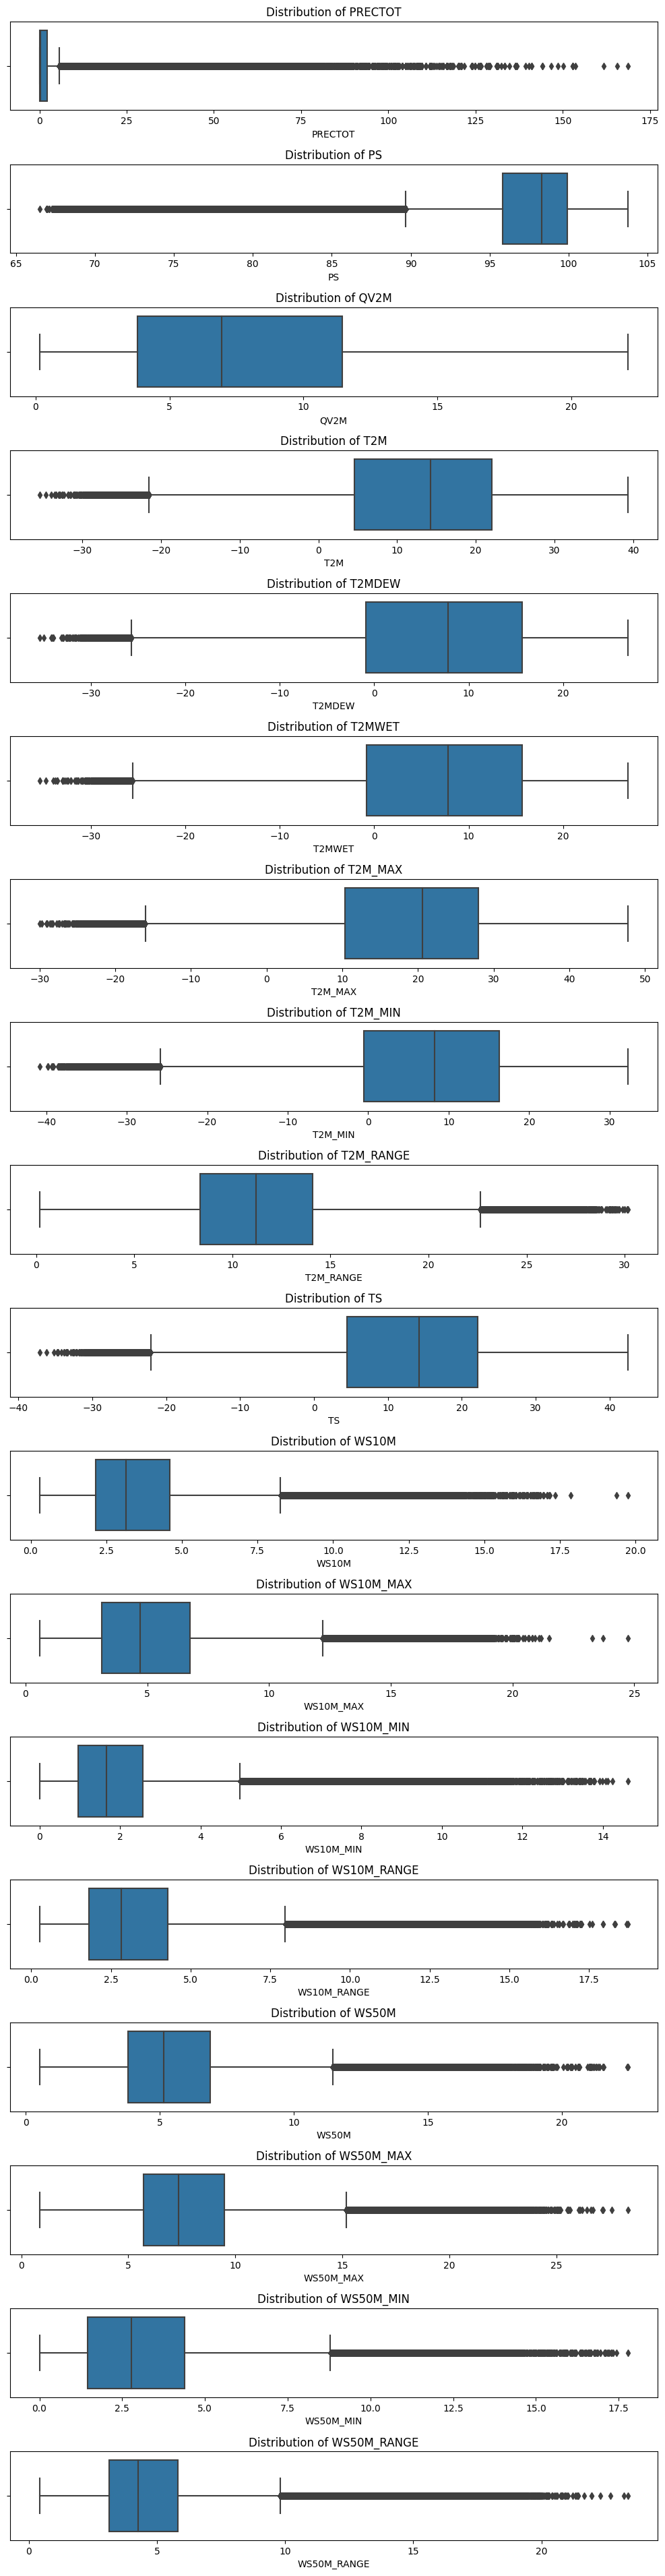

In [17]:
plt.figure(figsize=(10,40))
for x in (range(1,19)):
    plt.subplot(19,1,x)
    sns.boxplot(x =  measures_df.columns[x-1], data=measures_df)
    x_name = measures_df.columns[x-1]
    plt.title(f'Distribution of {x_name}')         
plt.tight_layout()

## Analysis:

Due to the extreme number of outliers in this dataset we can increase our standart 1.5x

In [18]:
outlier = Winsorizer(capping_method="gaussian",
                     tail="both",
                    fold=3,
                    variables = measures_list,
                    missing_values="ignore")

outlier.fit(df)

Winsorizer(fold=3, missing_values='ignore', tail='both',
           variables=['PRECTOT', 'PS', 'QV2M', 'T2M', 'T2MDEW', 'T2MWET',
                      'T2M_MAX', 'T2M_MIN', 'T2M_RANGE', 'TS', 'WS10M',
                      'WS10M_MAX', 'WS10M_MIN', 'WS10M_RANGE', 'WS50M',
                      'WS50M_MAX', 'WS50M_MIN', 'WS50M_RANGE'])

In [19]:
# What are our new min and max values?
outlier.right_tail_caps_

{'PRECTOT': 21.457332889763816,
 'PS': 112.98145673264875,
 'QV2M': 22.040143267571025,
 'T2M': 45.81043083884796,
 'T2MDEW': 37.64229397343022,
 'T2MWET': 37.515854398758336,
 'T2M_MAX': 53.57596019370604,
 'T2M_MIN': 39.374460380757405,
 'T2M_RANGE': 23.36126392532202,
 'TS': 46.547769510492124,
 'WS10M': 9.107009452404295,
 'WS10M_MAX': 13.030572340296782,
 'WS10M_MIN': 5.948028992777654,
 'WS10M_RANGE': 9.111675981756195,
 'WS50M': 12.428446678611095,
 'WS50M_MAX': 16.338650155855152,
 'WS50M_MIN': 9.451411079893987,
 'WS50M_RANGE': 11.25028258331134}

In [20]:
outlier.left_tail_caps_

{'PRECTOT': -16.028199932519247,
 'PS': 80.31327285923982,
 'QV2M': -6.288604198303655,
 'T2M': -20.01197101084471,
 'T2MDEW': -23.54359335865859,
 'T2MWET': -23.345978151114338,
 'T2M_MAX': -16.041739656531703,
 'T2M_MIN': -24.334627836020694,
 'T2M_RANGE': -0.8668619673969431,
 'TS': -20.597914229216336,
 'WS10M': -1.978858555493534,
 'WS10M_MAX': -2.624737719236686,
 'WS10M_MIN': -2.1067186963320674,
 'WS10M_RANGE': -2.5471408257272423,
 'WS50M': -1.3628487526129485,
 'WS50M_MAX': -0.6810523647962619,
 'WS50M_MIN': -3.208255728536831,
 'WS50M_RANGE': -1.835835921316768}

In [21]:
# Apply the Winsorizer to our main DataFrame
df = outlier.transform(df)

# Distribution of Categorical Variables

In [22]:
# Create a new categorical DataFrame for visualization
categorical_column_list = ['score','year','month','day']
df_categorical = df[['score','year','month','day']]

<Figure size 1000x4000 with 0 Axes>

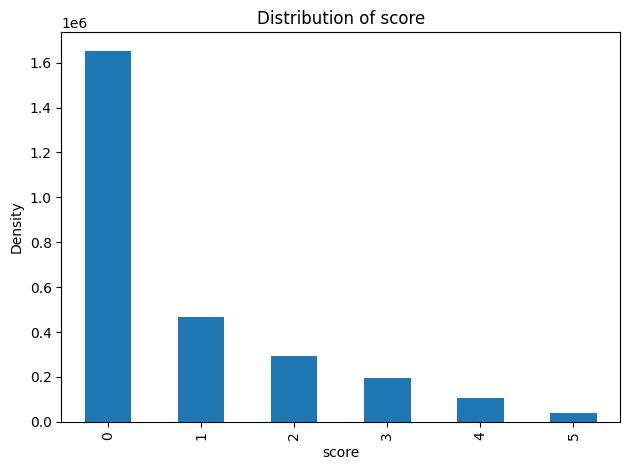

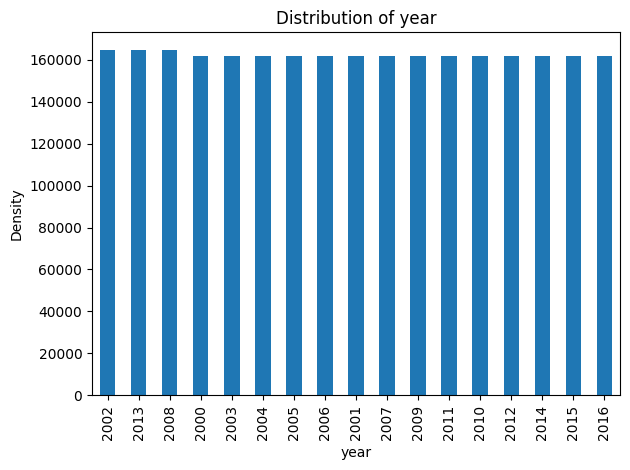

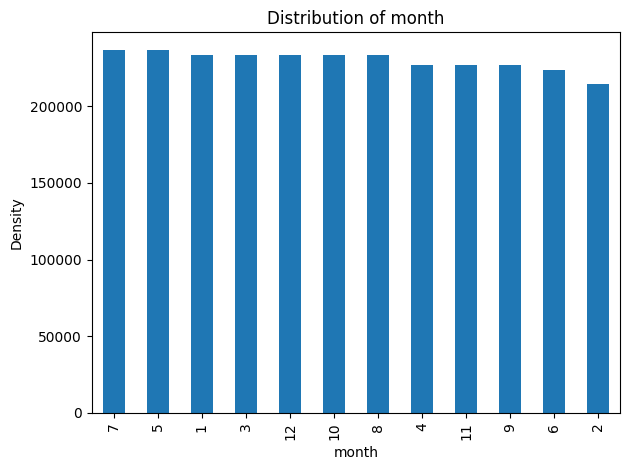

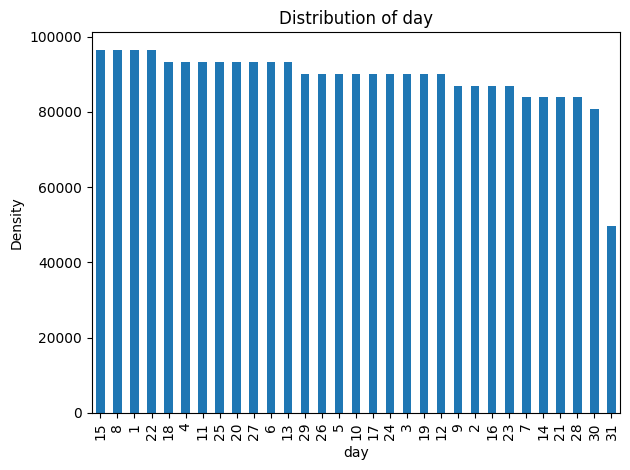

In [23]:
plt.figure(figsize=(10,40))
for col_name in categorical_column_list:
    plt.figure()
    df_categorical[col_name].value_counts().plot(kind = 'bar')
    x_name = col_name
    y_name = 'Density'
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.title('Distribution of {x_name}'.format(x_name=x_name))
    plt.tight_layout()

## Analysis:

We can observe the uniform distribution of days, months and years but we still have the unuevenly distributed "scores" or our target counts

## Correlation Matrix

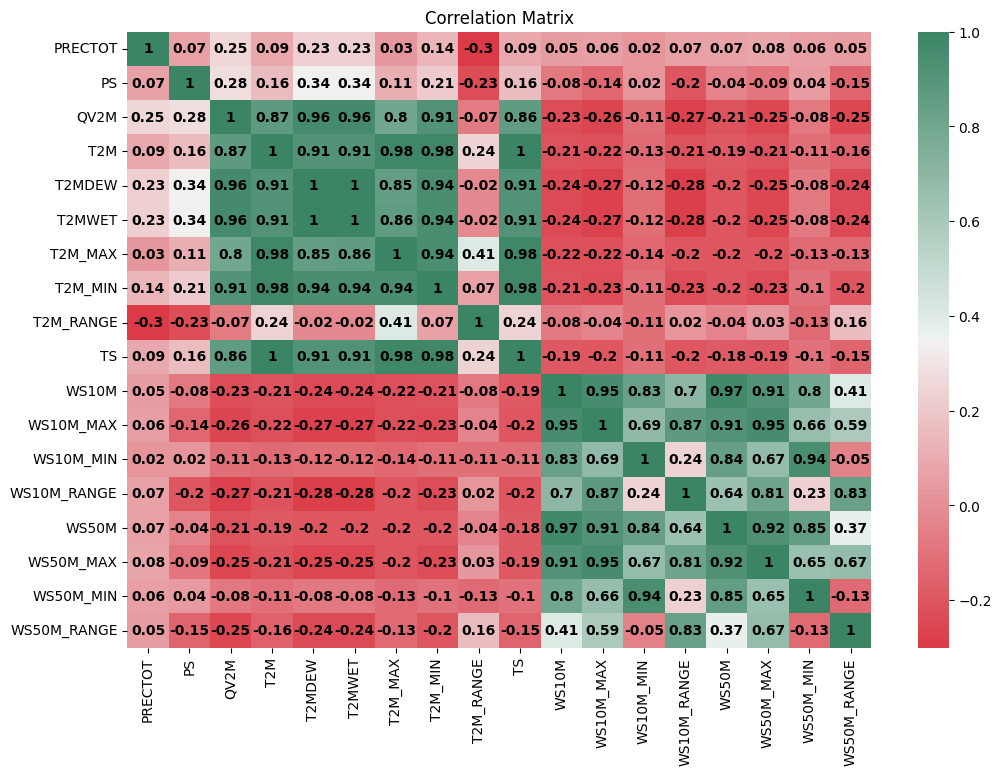

In [24]:
# Get .corr and visualize with Seaborn for an easier visual analysis of our features
correlation_matrix = measures_df.corr().round(2)

plt.figure(figsize=(12,8))
sns.heatmap(data=correlation_matrix, annot=True, annot_kws={"size": 10, "weight": "bold", "color": "black"}, cmap=sns.diverging_palette(10, 150, as_cmap=True))
plt.title("Correlation Matrix")
plt.show()

### Analysis: 

There're strong positive and negative correlation between, respectively, T2M and it's sub categories and WS10 and it's sub categories


# Data Preparation

## Column and Data Standardization

In [25]:
# We make sure our column names and values are in a single form. In this case there're no string values
df.columns = df.columns.str.lower().str.replace(" ","_")
df.head()

,fips,date,prectot,ps,qv2m,t2m,t2mdew,t2mwet,t2m_max,t2m_min,...,ws10m_min,ws10m_range,ws50m,ws50m_max,ws50m_min,ws50m_range,score,year,month,day
3,1001,2000-01-04,15.95,100.29,6.42,11.40,6.09,6.10,18.09,2.16,...,2.08,3.59,6.73,9.31,3.74,5.58,1,2000,1,4
10,1001,2000-01-11,1.33,100.40,6.63,11.48,7.84,7.84,18.88,5.72,...,1.05,1.43,3.55,6.38,1.71,4.67,2,2000,1,11
17,1001,2000-01-18,1.11,100.39,9.53,14.28,13.26,13.26,18.04,8.98,...,1.67,1.92,5.19,6.40,3.84,2.55,2,2000,1,18
24,1001,2000-01-25,0.00,100.11,2.05,-0.78,-7.93,-7.72,5.65,-5.46,...,2.28,2.32,5.75,8.03,3.96,4.07,2,2000,1,25
31,1001,2000-02-01,0.00,101.00,3.36,2.06,-1.73,-1.70,11.02,-4.21,...,0.88,1.86,4.18,6.38,1.27,5.11,1,2000,2,1


# Splitting into Datasets (X, y)

In [26]:
# Drop useless columns | remove fips and date 
df = df.drop(columns=["date", "fips"])

# X, y
X = df.drop(["score"], axis=1)
y = df["score"]

# Get shapes of our variables and targets
print("X.shape: {} \ny.shape: {}".format(X.shape, y.shape))

X.shape: (2756796, 21) 
y.shape: (2756796,)


# Feature Selection

## Train Test Split

In [27]:
# Split our data for train and test sets for validation, test size is 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
print("Train features shape", X_train.shape)
print("Train target shape", y_train.shape)
print("Test features shape", X_test.shape)
print("Test target shape", y_test.shape)

Train features shape (2205436, 21)
Train target shape (2205436,)
Test features shape (551360, 21)
Test target shape (551360,)


# Standart Scaling

For feeding into our models, we prefer smaller numbers for efficiency and can select from a variety of different scaling methods, such as MinMax, Normalizer ..etc. 

But for this project we will move forward with Standart Scaler for ease of use.

In [29]:
# Initialize our Standart Scaler
sc = StandardScaler()

# Use .fit and .transform in the same line with fit_transform on X_train 
X_train = sc.fit_transform(X_train)
# only transform X_test
X_test = sc.transform(X_test)
# This process doesn't remember the column names and X_train is now a Numpy array not a DataFrame
X_train

array([[ 9.31468301e-02,  5.69970059e-02, -3.97144755e-01, ...,
        -6.12291602e-01, -7.31597359e-01, -4.19632720e-01],
       [ 1.18038625e+00,  4.14559190e-01,  6.19613410e-01, ...,
        -1.22486327e+00,  7.18762013e-01, -6.47002081e-01],
       [-5.06281750e-01,  9.67694060e-01,  2.78575775e-01, ...,
        -6.12291602e-01,  1.29890576e+00, -8.74371442e-01],
       ...,
       [ 1.96791139e+00, -5.81083576e-01,  1.16188443e+00, ...,
         2.80069989e-04,  1.00883389e+00, -1.92263358e-01],
       [-4.83544804e-01,  6.88498960e-02, -9.03405591e-01, ...,
        -1.42905383e+00, -1.60181298e+00, -7.60686761e-01],
       [-4.91812784e-01,  1.06449266e+00, -1.38718721e-01, ...,
         1.02123286e+00,  1.29890576e+00, -4.19632720e-01]])

# Feature Selection

We will deploy Random Forest Classifier algorithm to help us select the most significant features.

### What are the most impactful features in this dataset?

We created a sub dataset of 100,000 samples for visualization demonstration purposes. In a real-case scenario we would pass the entire dataset.

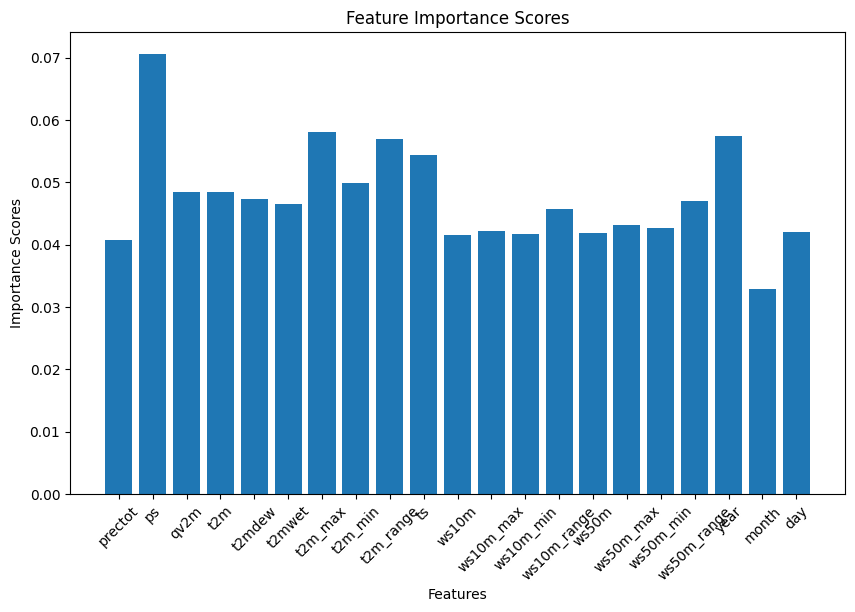

In [32]:
X_scaled_sub = X_train[:100000]
y_scaled_sub = y_train[:100000]

classifier = RandomForestClassifier(n_estimators=10) # n is 100 by default we reduced it
classifier.fit(X_scaled_sub, y_scaled_sub)

feature_importance = classifier.feature_importances_

plt.figure(figsize=(10, 6))
plt.bar(X.columns, feature_importance)
# plt.bar(X_train.columns, feature_importance)

plt.xlabel('Features')
plt.ylabel('Importance Scores')
plt.title('Feature Importance Scores')
plt.xticks(rotation=45)
plt.show()

### Analysis:

The importance values are all under 10% so we will pick a big majority of features and we have to keep in mind that we only used a small portion of our dataset in this graph but the essence is there.

In [33]:
# Created a backup copy for ease of use while developing the code
Xi = X.copy()

# Initiate Random Forest Classifier 
model = RandomForestClassifier(n_estimators=10) # n_estimators is the hyperparameter

rfe = RFE(model, n_features_to_select=15) # n_features_to_select is chosen on a trial and error basis
fit = rfe.fit(X_train, y_train)

# Get evaluation values
print("Num Features: %s" % (fit.n_features_)) # Number of features
print("Selected Features: %s" % (fit.support_))  # Get index .any()
print("Feature Ranking: %s" % (fit.ranking_))
selected_features = Xi.columns[(fit.get_support())]  # Get feature column names
print(selected_features)

Num Features: 15
Selected Features: [False  True  True  True  True False  True  True  True  True  True False
 False  True  True  True False  True  True False  True]
Feature Ranking: [4 1 1 1 1 2 1 1 1 1 1 5 6 1 1 1 3 1 1 7 1]
Index(['ps', 'qv2m', 't2m', 't2mdew', 't2m_max', 't2m_min', 't2m_range', 'ts',
       'ws10m', 'ws10m_range', 'ws50m', 'ws50m_max', 'ws50m_range', 'year',
       'day'],
      dtype='object')


In [34]:
# Apply best features to our data
Xi = Xi.drop(columns=['prectot', 't2mwet', 'ws10m_max', 'ws10m_min', 'ws50m_min', 'month'])

X_train, X_test, y_train, y_test = train_test_split(Xi, y, test_size=0.2, random_state=0)

print("Train features shape", X_train.shape)
print("Train target shape", y_train.shape)
print("Test features shape", X_test.shape)
print("Test target shape", y_test.shape)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

Train features shape (2205436, 15)
Train target shape (2205436,)
Test features shape (551360, 15)
Test target shape (551360,)


# Sampling

We will utilize the SMOTE library to help us generalize the underrepresented data.

In [35]:
sm = SMOTE(random_state = 5)
X_train_ures_SMOTE, y_train_ures_SMOTE = sm.fit_resample(X_train, y_train)

### How many samples did we produce?

In [36]:
print('Before OverSampling, the shape of train_X: {}'.format(X_train.shape))
print('Before OverSampling, the shape of train_y: {} \n'.format(y_train.shape))

print('After OverSampling, the shape of train_X: {}'.format(X_train_ures_SMOTE.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_ures_SMOTE.shape))

print("Counts of label '0' - Before Oversampling:{}, After OverSampling: {}".format(sum(y_train == 0),sum(y_train_ures_SMOTE == 0)))
print("Counts of label '1' - Before Oversampling:{}, After OverSampling: {}".format(sum(y_train == 1),sum(y_train_ures_SMOTE == 1)))
print("Counts of label '2' - Before Oversampling:{}, After OverSampling: {}".format(sum(y_train == 2),sum(y_train_ures_SMOTE == 2)))
print("Counts of label '3' - Before Oversampling:{}, After OverSampling: {}".format(sum(y_train == 3),sum(y_train_ures_SMOTE == 3)))
print("Counts of label '4' - Before Oversampling:{}, After OverSampling: {}".format(sum(y_train == 4),sum(y_train_ures_SMOTE == 4)))
print("Counts of label '5' - Before Oversampling:{}, After OverSampling: {}".format(sum(y_train == 5),sum(y_train_ures_SMOTE == 5)))

Before OverSampling, the shape of train_X: (2205436, 15)
Before OverSampling, the shape of train_y: (2205436,) 

After OverSampling, the shape of train_X: (7924818, 15)
After OverSampling, the shape of train_y: (7924818,) 

Counts of label '0' - Before Oversampling:1320803, After OverSampling: 1320803
Counts of label '1' - Before Oversampling:373855, After OverSampling: 1320803
Counts of label '2' - Before Oversampling:236625, After OverSampling: 1320803
Counts of label '3' - Before Oversampling:157571, After OverSampling: 1320803
Counts of label '4' - Before Oversampling:85208, After OverSampling: 1320803
Counts of label '5' - Before Oversampling:31374, After OverSampling: 1320803


# Models

## Decision Tree

Let's initialize our first algorithm

In [37]:
# Create our DT Classifier with the default criterion
DT_classifier_SMOTE = tree.DecisionTreeClassifier(criterion='gini', max_depth=70)
# Fit to our SMOTE enhanced dataframe
DT_classifier_SMOTE.fit(X_train_ures_SMOTE,y_train_ures_SMOTE)
# Predict on the X_test dataset
y_pred_SMOTE = DT_classifier_SMOTE.predict(X_test)

In [38]:
# Save our DT Classifier with Pickle for further use
pickle.dump(DT_classifier_SMOTE, open('DT_classifier_SMOTE.pkl', 'wb'))

# Model Evaluation Metrics

### Cross Validation

We evaluate our model's performance by initializing two functions for replicability.

However for this application, we will slice down our dataset since it has to run K-Fold Cross Validation multiple times, and that would take a considerable amount of time.

Cross-Validation Accuracy: 0.52 ± 0.00
-------------------------------------------------------
Model Accuracy: 0.54
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.75      0.73      0.74     60242
           1       0.28      0.29      0.28     16973
           2       0.22      0.23      0.23     10567
           3       0.22      0.23      0.23      6984
           4       0.22      0.22      0.22      3758
           5       0.22      0.22      0.22      1476

    accuracy                           0.54    100000
   macro avg       0.32      0.32      0.32    100000
weighted avg       0.55      0.54      0.55    100000

-------------------------------------------------------


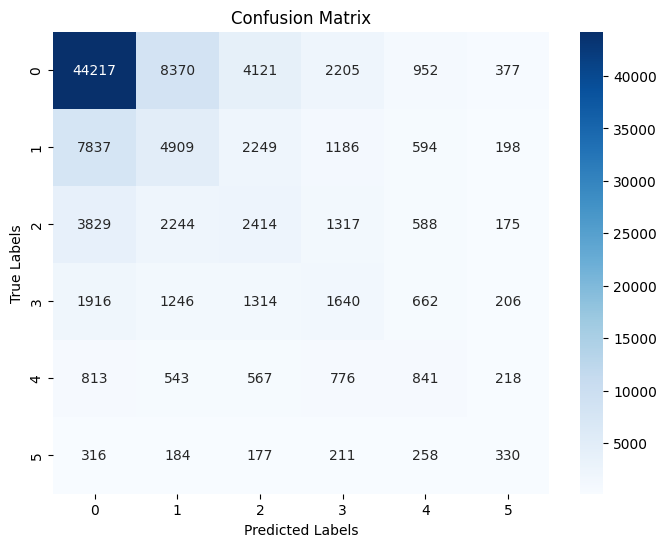

In [45]:
# Info plot gets us the model accuracy score, classification report and a visualized confusion matrix for easier observation 
def info_plot(test, pred, model):
    accuracy = accuracy_score(test, pred)
    print("-"*55)
    print(f"Model Accuracy: {accuracy:.2f}")
    print("-"*55)
    print(classification_report(test, pred))
    print("-"*55)
    plt.figure(figsize=(8,6))
    cm = confusion_matrix(test, pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"Confusion Matrix")
    plt.show()
    

# Expects the model, train and test sets for X and y, for calculating the Cross Validation Score calculation.
# Also runs info_plot, this is why we request y_test even though we don't us it in this function

def evaluate_model(model, X_train, y_train, X_test, y_test):
    # get K-Fold CV scores
    cross_val_avg = cross_val_score(estimator=model, X=X_train, y=y_train, cv=3, scoring="accuracy")#f1 ile degistirdik accuracy'i
    print(f"Cross-Validation Accuracy: {cross_val_avg.mean():.2f} ± {cross_val_avg.std():.2f}")
    
    # calculate y_pred here for infoplot
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    info_plot(y_test, y_pred, model)

# Slice our dataset into sub 
X_train_ures_SMOTE_sub = X_train_ures_SMOTE[:100000]
y_train_ures_SMOTE_sub = y_train_ures_SMOTE[:100000]
X_test_sub = X_test[:100000]
y_test_sub = y_test[:100000]
    
evaluate_model(DT_classifier_SMOTE, X_train_ures_SMOTE_sub, y_train_ures_SMOTE_sub, X_test_sub, y_test_sub)

Here's a simpler way of visualizing 

In [46]:
print('Performance of Decision Tree Algorithm with SMOTE Upsampling:\n')
print(confusion_matrix(y_test, y_pred_SMOTE))
print(classification_report(y_test, y_pred_SMOTE))
print('Accuracy:',accuracy_score(y_test, y_pred_SMOTE))
print('Precision:',precision_score(y_test, y_pred_SMOTE, average='weighted'))
print('Recall:',recall_score(y_test, y_pred_SMOTE, average='weighted'))
print('F1 Score:',f1_score(y_test, y_pred_SMOTE, average='weighted'))

Performance of Decision Tree Algorithm with SMOTE Upsampling:

[[289980  26111   8110   4464   2066    696]
 [ 20771  56556  11404   2827   1164    367]
 [  4712  11106  33563   7329   1629    367]
 [  1988   2282   7553  22361   4484    563]
 [   740    728   1254   4349  12363   1623]
 [   206    183    236    394   1636   5195]]
              precision    recall  f1-score   support

           0       0.91      0.87      0.89    331427
           1       0.58      0.61      0.60     93089
           2       0.54      0.57      0.56     58706
           3       0.54      0.57      0.55     39231
           4       0.53      0.59      0.56     21057
           5       0.59      0.66      0.62      7850

    accuracy                           0.76    551360
   macro avg       0.61      0.65      0.63    551360
weighted avg       0.77      0.76      0.77    551360

Accuracy: 0.7617854033662217
Precision: 0.7702160300711779
Recall: 0.7617854033662217
F1 Score: 0.7655724010531016


### ROC Curve 

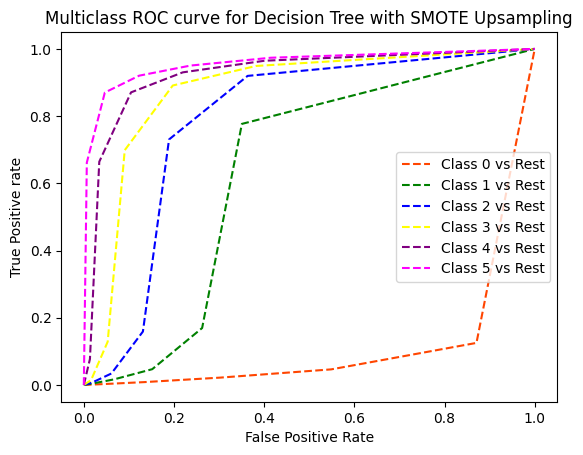

In [47]:
fpr = dict()
tpr = dict()
thresh = dict()

for i in range(6):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_pred_SMOTE, pos_label=i)

plt.plot(fpr[0], tpr[0], linestyle='--',color='orangered', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='yellow', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='purple', label='Class 4 vs Rest')
plt.plot(fpr[5], tpr[5], linestyle='--',color='magenta', label='Class 5 vs Rest')

plt.title('Multiclass ROC curve for Decision Tree with SMOTE Upsampling')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC curve for Decision Tree with SMOTE Upsampling',dpi=300)

## KNN Classifier

We didn't use resampling technique in this model input.

In [48]:
knn_classifier = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski') # default metric = "minkowski"
knn_classifier.fit(X_train, y_train)
y_pred_knn = knn_classifier.predict(X_test)

In [49]:
print('Performance of KNN Algorithm without resampling:\n')
print(confusion_matrix(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))
print('Accuracy:',accuracy_score(y_test, y_pred_knn))
print('Precision:',precision_score(y_test, y_pred_knn, average='weighted'))
print('Recall:',recall_score(y_test, y_pred_knn, average='weighted'))
print('F1 Score:',f1_score(y_test, y_pred_knn, average='weighted'))

Performance of KNN Algorithm without resampling:

[[309787  16166   3098   1543    640    193]
 [ 31225  51539   8165   1526    521    113]
 [ 10725  11898  29499   5512    903    169]
 [  5417   3059   7815  19455   3185    300]
 [  2329   1037   1706   4427  10380   1178]
 [   688    266    366    530   1651   4349]]
              precision    recall  f1-score   support

           0       0.86      0.93      0.90    331427
           1       0.61      0.55      0.58     93089
           2       0.58      0.50      0.54     58706
           3       0.59      0.50      0.54     39231
           4       0.60      0.49      0.54     21057
           5       0.69      0.55      0.61      7850

    accuracy                           0.77    551360
   macro avg       0.66      0.59      0.62    551360
weighted avg       0.76      0.77      0.76    551360

Accuracy: 0.7708375652930934
Precision: 0.757389804479083
Recall: 0.7708375652930934
F1 Score: 0.7620098407865401


## ROC Curve 

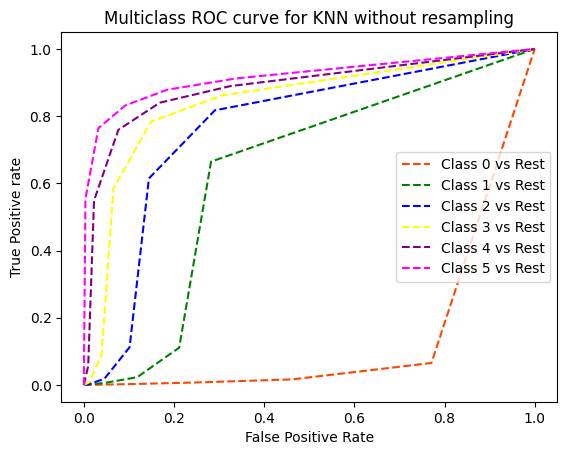

In [50]:
fpr = dict()
tpr = dict()
thresh = dict()

for i in range(6):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_pred_knn, pos_label=i)

plt.plot(fpr[0], tpr[0], linestyle='--',color='orangered', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='yellow', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='purple', label='Class 4 vs Rest')
plt.plot(fpr[5], tpr[5], linestyle='--',color='magenta', label='Class 5 vs Rest')

plt.title('Multiclass ROC curve for KNN without resampling')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC curve for KNN without resampling',dpi=300)

## Hyperparameter Optimizing

We are searching for the best parameters over Cross Validation to confirm the best settings by using GridSearchCV.

In [52]:
k_range = list(range(1, 3)) # usually range = 1-12 but it's slow
param_grid = dict(n_neighbors=k_range)

# Apply GridSearchCV to our model to find the best parameters
grid = GridSearchCV(knn_classifier, param_grid, cv=3, scoring='accuracy', return_train_score=False,verbose=1)
grid_search=grid.fit(X_train, y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


In [53]:
# Get Cross Validation scores

# Create a new Dataframe and use the n_largest(5) on the test_score to analyze
score_df = pd.DataFrame(grid_search.cv_results_)
score_df.nlargest(5,"mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,6.288399,0.029719,153.846872,0.134066,1,{'n_neighbors': 1},0.773378,0.773162,0.774137,0.773559,0.000418,1
1,6.271406,0.016228,240.536170,0.521366,2,{'n_neighbors': 2},0.758188,0.757919,0.759016,0.758374,0.000467,2


Re-Run the KNN Classifier here after GridSearchCV and set the right parameters.

But it would further increase the already slow working notebook so we'll skip this step

In [ ]:
# # We concluded that n_neighbors = 1 is the best parameter and apply it here

# knn_classifier = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')
# knn_classifier.fit(X_train, y_train)
# y_pred_knn = knn_classifier.predict(X_test)

# # Save best model

# pickle.dump(knn_classifier, open('knn_classifier.pkl', 'wb'))

# # Evaluate the model

# print('Performance of KNN Algorithm without resampling - After Hyperparameter Tuning:\n')
# print(confusion_matrix(y_test, y_pred_knn))
# print(classification_report(y_test, y_pred_knn))
# print('Accuracy:',accuracy_score(y_test, y_pred_knn))
# print('Precision:',precision_score(y_test, y_pred_knn, average='weighted'))
# print('Recall:',recall_score(y_test, y_pred_knn, average='weighted'))
# print('F1 Score:',f1_score(y_test, y_pred_knn, average='weighted'))

# Unsupervized Learning

In [54]:
#Create a copy of X for ease of use
X = Xi.copy()

## KMeans Clustering

The problem is we have around almost 8 million rows of sample in our data and the calculations will take longer than 2 hours at a minimum and we won't be able to draw a Silhouette Graph after to find the best n_neighbors' value.

In order to tackle this problem we will first try Mini Batch KMeans to make the algorithm run faster and then go to sub sampling of around 100.000 rows of samples if that is also extremely slow.

In [55]:
# kmeans = KMeans(n_clusters=3, random_state=42)

# kmeans.fit(X)

# labels = kmeans.predict(X)

In [56]:
# np.unique(labels, return_counts=True)

In [57]:
# silhouettes = []
# ks = list(range(2, 12))
# for n_cluster in ks:
#     kmeans = KMeans(n_clusters=n_cluster).fit(X)
#     label = kmeans.labels_
#     sil_coeff = silhouette_score(X, label, metric='euclidean')
#     print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))
#     silhouettes.append(sil_coeff)

# plt.figure(figsize=(12, 8))    
# plt.subplot(211)
# plt.scatter(ks, silhouettes, marker='x', c='r')
# plt.plot(ks, silhouettes)
# plt.xlabel('k')
# plt.ylabel('Silhouette score')

These 3 cells took more than 8 hours to run and the Kaggle notebook shut down for excessive use.

# Mini Batch KMeans

In [58]:
kmeans = MiniBatchKMeans(n_clusters=3, batch_size=1000) #default batch_size=100

kmeans.fit(X)
labels = kmeans.predict(X)

In [59]:
np.unique(labels, return_counts=True)

(array([0, 1, 2], dtype=int32), array([1186558,  962203,  608035]))

# Sub Sampling our Data

To be able to visualize a Silhouette score graph we will create a sub dataset of 100,000 for demonstration purposes.

In [60]:
# Scaling our dataset without labels
X_scaled = sc.fit_transform(X)
# Slice our X in a new DataFrame X_scaled_sub
X_scaled_sub = X_scaled[:100000]

# Mini Batch KMeans, Sub Sampled Data

For n_clusters=2, The Silhouette Coefficient is 0.27801513760823937
For n_clusters=3, The Silhouette Coefficient is 0.22033475044815867
For n_clusters=4, The Silhouette Coefficient is 0.17622445255469404
For n_clusters=5, The Silhouette Coefficient is 0.13825646081316395
For n_clusters=6, The Silhouette Coefficient is 0.14692550748050545
For n_clusters=7, The Silhouette Coefficient is 0.12809793986530837
Time taken: 651.37 seconds


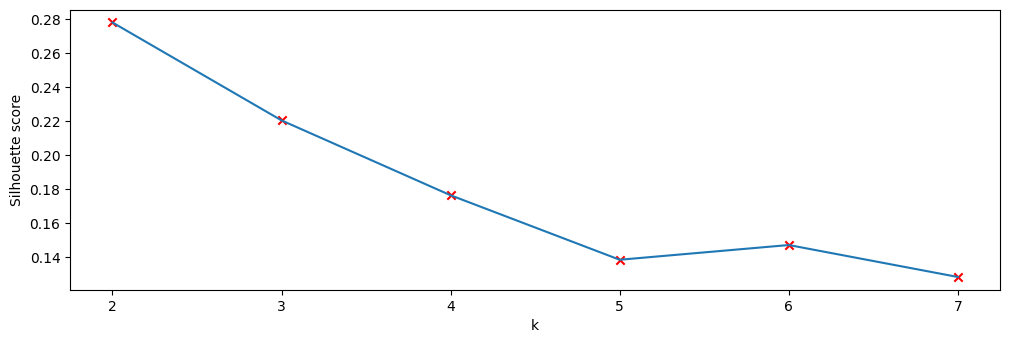

In [61]:
# To calculate the processing time, we initialize a stopwatch
start_time = time.time()

silhouettes = []
ks = list(range(2, 8))
for n_cluster in ks:
    kmeans = MiniBatchKMeans(n_clusters=n_cluster, verbose=0).fit(X_scaled_sub)
    label = kmeans.labels_
    sil_coeff = silhouette_score(X_scaled_sub, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))
    silhouettes.append(sil_coeff)

plt.figure(figsize=(12, 8))    
plt.subplot(211)
plt.scatter(ks, silhouettes, marker='x', c='r')
plt.plot(ks, silhouettes)
plt.xlabel('k')
plt.ylabel('Silhouette score')

# How long did it take to run? Here's the time in seconds
print("Time taken: {:.2f} seconds".format(time.time() - start_time))